# Aplicação MobileNets

#### Identificação do dataset:

* O número **0** será utilizado para categorizar "Não-MPOX".
    * Total de imagens: 2413


* O número **1** será utilizado para categorizar "MPOX".
    * Total de imagens: 1675

_Total geral de imagens: 6810_

* Proporção de treino e teste: _80:20_


#### Organização do diretório do dataset:

* dataset/
    - false/
    - true/

# Preparo Inicial

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Activation, Conv2D, BatchNormalization, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam, RMSprop
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.applications import imagenet_utils, MobileNetV2, ResNet50


from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping

import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

IMG_SHAPE = (224,224,3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/IFES/TCC/Detector_Monkeypox')

In [ ]:
os.chdir('dataset/')


if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0,2): ##### alterar a porcentagem de imagens de treino ####

        shutil.move(f'{i}', 'train') # Mover todos arquivos do dataset para a pasta "train"
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 418) # Total de 681 imagens de Validação (~10%)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 419) # Total de 681 imagens de Teste (~10%)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')


os.chdir('../')

In [ ]:
train_path = 'dataset/train'
valid_path = 'dataset/valid'
test_path = 'dataset/test'

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(directory = train_path, target_size = (224,224), batch_size= 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(directory = valid_path, target_size = (224,224), batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(directory = test_path, target_size = (224,224), batch_size = 10, shuffle = False)

Found 1746 images belonging to 2 classes.
Found 836 images belonging to 2 classes.
Found 838 images belonging to 2 classes.


# Execução do Modelo

In [ ]:
model = Sequential()
model.add(MobileNetV2(input_shape = IMG_SHAPE,
                     include_top = False,
                     weights = 'imagenet'))
model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation = 'sigmoid'))
model.layers[0].trainable = False

9406464/9406464 [==============================] - 0s 0us/step


## Treino do Modelo

In [ ]:
model.compile(RMSprop(learning_rate=.0001), loss = 'binary_crossentropy', metrics = 'accuracy')

early_stopping = EarlyStopping(monitor='accuracy', patience=5, mode='max', verbose=2)

In [ ]:
history = model.fit(train_batches, validation_data = valid_batches, verbose = 2, epochs = 100, callbacks=[early_stopping])

Epoch 1/100
175/175 - 457s - loss: 0.7112 - accuracy: 0.6100 - val_loss: 0.6270 - val_accuracy: 0.6998 - 457s/epoch - 3s/step
Epoch 2/100
175/175 - 111s - loss: 0.5593 - accuracy: 0.7646 - val_loss: 0.5455 - val_accuracy: 0.7596 - 111s/epoch - 632ms/step
Epoch 3/100
175/175 - 103s - loss: 0.4926 - accuracy: 0.7990 - val_loss: 0.4882 - val_accuracy: 0.7835 - 103s/epoch - 590ms/step
Epoch 4/100
175/175 - 103s - loss: 0.4534 - accuracy: 0.8184 - val_loss: 0.4586 - val_accuracy: 0.8026 - 103s/epoch - 587ms/step
Epoch 5/100
175/175 - 102s - loss: 0.4268 - accuracy: 0.8305 - val_loss: 0.4401 - val_accuracy: 0.8122 - 102s/epoch - 585ms/step
Epoch 6/100
175/175 - 102s - loss: 0.4070 - accuracy: 0.8408 - val_loss: 0.4403 - val_accuracy: 0.8038 - 102s/epoch - 584ms/step
Epoch 7/100
175/175 - 111s - loss: 0.3914 - accuracy: 0.8459 - val_loss: 0.4108 - val_accuracy: 0.8278 - 111s/epoch - 636ms/step
Epoch 8/100
175/175 - 103s - loss: 0.3786 - accuracy: 0.8517 - val_loss: 0.3997 - val_accuracy: 0.83

### Predições

In [ ]:
import pickle

with open('/content/drive/MyDrive/IFES/TCC/Detector_Monkeypox/history/trainHistDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


np.save('/content/drive/MyDrive/IFES/TCC/Detector_Monkeypox/history/trainHistDict.npy',history.history)

In [ ]:
history=np.load('/content/drive/MyDrive/IFES/TCC/Detector_Monkeypox/history/trainHistDict.npy',allow_pickle='TRUE').item()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/IFES/TCC/Detector_Monkeypox/modelos/modelo_gerado_final1')

In [ ]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title="Matriz de Confusão",
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz normalizada")
    else:
        print("Matriz sem normalização")

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Eixo Verdadeiro')
    plt.xlabel('Eixo Predito')
    plt.show()

In [ ]:
def plot_graph_acc(hist, epoch):

  # Dados de treinamento
  epochs = list(range(1, epoch))
  train_accuracy = hist['accuracy']
  val_accuracy = hist['val_accuracy']

  # Plotar o gráfico
  plt.plot(epochs, [acc * 100 for acc in train_accuracy], label='Acurácia de Treinamento')
  plt.plot(epochs, [acc * 100 for acc in val_accuracy], label='Acurácia de Validação')

  plt.xlabel('Épocas de Treinamento')
  plt.ylabel('Acurácia (%)')
  plt.title('Evolução da Acurácia durante o Treinamento')
  plt.legend()
  plt.show()


In [ ]:
def plot_graph_time(hist, epoch):


In [ ]:
test_labels = test_batches.classes

predictions = model.predict(x = test_batches, verbose = 1)

cm = confusion_matrix(y_true = test_labels, y_pred = predictions.argmax(axis=1))

cm_plot_labels = ['Não-MPOX', 'MPOX']

84/84 [==============================] - 538s 6s/step


Matriz sem normalização


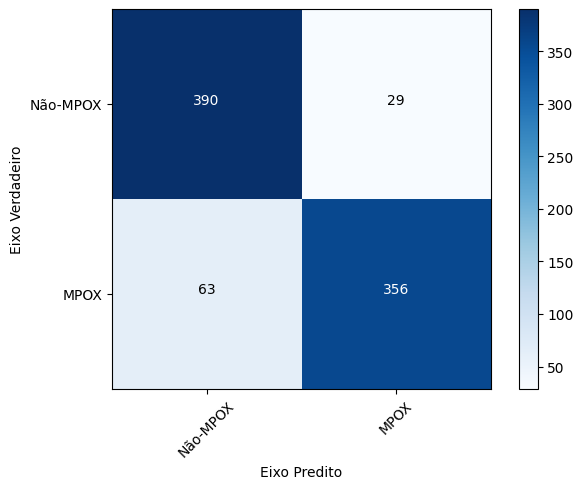

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title = "Matriz de Confusão")

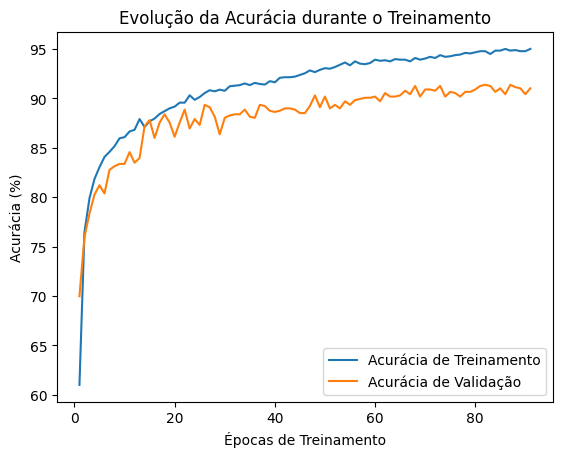

In [ ]:
plot_graph_acc(history, epoch = 92)

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, predictions.argmax(axis=1))
roc_auc = auc(fpr, tpr)

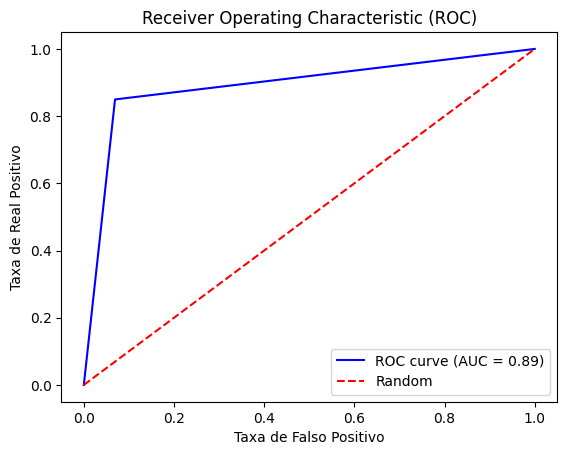

In [ ]:
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Real Positivo')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/IFES/TCC/Detector_Monkeypox/modelos/modelo_gerado_final2.h5')